# Import Dependencies, Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pysmiles import read_smiles
import networkx as nx
from rdkit.Chem import AllChem
import torch
import scipy
import rdkit
import os
import pickle

In [2]:
dataframe = pd.read_csv('../data/train/raw/rev02.csv', delimiter=',')[['Chromophore', 'Emission max (nm)']].dropna()

# Data Exploration

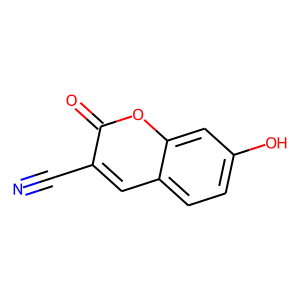

In [3]:
smiles_0 = dataframe['Chromophore'][0]
mol_0 = rdkit.Chem.MolFromSmiles(smiles_0)
rdkit.IPythonConsole.Draw.MolToImage(mol_0)

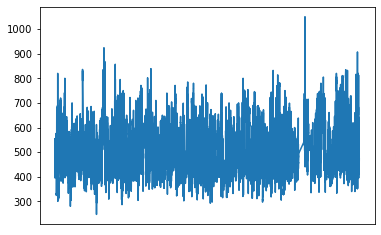

In [4]:
plt.xticks([])
plt.plot(dataframe['Emission max (nm)'])
plt.show()

# Preprocess Data

## Define Constants

In [5]:
MAX_SIZE = 150
atoms = ['C', 'N', 'O', 'F', 'S', 'B', 'Cl', 'Si', 'Br', 'P', 'I', 'Se', '[OOV]']

## TODO: 

* Process Data into proper format: 

### No Need to Re-Run When Finalized!

In [6]:
# i = 0
# l = []
# for item in mols:
#     if i >= 5:
#         break
#     i += 1
#     tmp = []
#     node_map = item.nodes(data='element')
#     for j in range(len(node_map)):
#         tmp.append(to_one_hot(node_map[j]))
#     l.append(tmp)
# pad_vec(l[0], 150)

# with open('data', 'wb') as file:
#   pickle.dump(data_dict, file, protocol=pickle.HIGHEST_PROTOCOL)

# GCN Implementation
Concept From: [DeepFindr Article][0]

Other Documentation:
1. [PyTorch Geometric GCN][1]
2. [Kipf and Welling][2]

This network incorporates the torch_geometric implementation of the Graph Convolutional Network outlined by Kipf and Welling to predict emission wavelength based on the SMILES representation of a chromophore.

[0]: https://deepfindr.com/understanding-graph-neural-networks-part-3-3/ "Title"
[1]: https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html#implementing-the-gcn-layer "Title"
[2]: https://arxiv.org/abs/1609.02907 "Title"

## TODO/FIXME


* Need to incorporate solvent data into network input; currently only using chromophore. :weary:
* Currently discarding stereochemistry details. TODO: implement isomer details in edge_attribute matrix?
* Current graph features are only one-hot encodings of the atoms; may be suboptimal for molecular representation.
* Other Optimizations:
    - Dropouts
    - Better pooling layers
    - Batch norm
    - Hyperparameter tuning

In [7]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool as gap, global_max_pool as gmp

In [8]:
# NOTE: data-dependent parameters
output_dim = 1
input_shape = len(atoms)
# NOTE: hyperparameters
embedding_size = 64

from torch.nn import Embedding
class GCN(torch.nn.Module):
  def __init__(self):
    super(GCN, self).__init__()
    torch.manual_seed(42)
    self.conv0 = GCNConv(input_shape, embedding_size) # embedding?
    self.conv1 = GCNConv(embedding_size, embedding_size)
    self.conv2 = GCNConv(embedding_size, embedding_size)
    self.conv3 = GCNConv(embedding_size, embedding_size)
    self.out = Linear(embedding_size*2, output_dim)
  
  def forward(self, x, edge_index, batch_index):
    hidden = F.tanh(self.conv0(x, edge_index))
    hidden = F.tanh(self.conv1(hidden, edge_index))
    hidden = F.tanh(self.conv2(hidden, edge_index))
    hidden = F.tanh(self.conv3(hidden, edge_index))
    hidden = torch.cat([gmp(hidden, batch_index), gap(hidden, batch_index)], dim=1)
    out = self.out(hidden)
    return out, hidden

In [9]:
model = GCN()
print(model)

GCN(
  (conv0): GCNConv(13, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)


# Model Training

In [10]:
from torch_geometric.data import DataLoader, Data
import warnings
warnings.filterwarnings('ignore')

with open('../data/train/processed/cro_emax', 'rb') as file:
  data_dict = pickle.load(file)
  
data = [Data(x=vec, edge_index=adj, y=y) for vec, adj, y in zip(data_dict['xs'], data_dict['edge_indices'], data_dict['ys'])]
  
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

data_size = len(data)
BATCH_SIZE = 64
loader = DataLoader(data[:int(data_size * 0.8)], batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(data[int(data_size * 0.8):], batch_size=BATCH_SIZE, shuffle=True)

In [11]:
dataframe.iloc[0]

Chromophore          N#Cc1cc2ccc(O)cc2oc1=O
Emission max (nm)                     410.0
Name: 0, dtype: object

In [12]:
def train_step(loader, history = True):
  log = []
  
  for batch in loader:
    batch.to(device)
    optimizer.zero_grad()
    pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch)
    loss = torch.sqrt(loss_fn(batch.y, pred))
    loss.backward()
    optimizer.step()
    if history:
      log.append([pred, batch.y])

  return loss, embedding, log

In [13]:
print("Starting training...")
losses = []
logs = []
for epoch in range(20):
    loss, h, log = train_step(loader)
    losses.append(loss)
    logs.extend(log)
    if epoch % 1 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")

Starting training...
Epoch 0 | Train Loss 464.8758850097656
Epoch 1 | Train Loss 451.6711730957031
Epoch 2 | Train Loss 408.30255126953125
Epoch 3 | Train Loss 380.97509765625
Epoch 4 | Train Loss 365.6629333496094
Epoch 5 | Train Loss 308.6788330078125
Epoch 6 | Train Loss 295.46844482421875
Epoch 7 | Train Loss 272.34332275390625
Epoch 8 | Train Loss 237.7938690185547
Epoch 9 | Train Loss 217.80982971191406
Epoch 10 | Train Loss 195.41477966308594
Epoch 11 | Train Loss 156.81710815429688
Epoch 12 | Train Loss 132.8201446533203
Epoch 13 | Train Loss 113.60861206054688
Epoch 14 | Train Loss 105.59407806396484
Epoch 15 | Train Loss 104.55377960205078
Epoch 16 | Train Loss 108.45044708251953
Epoch 17 | Train Loss 77.49681091308594
Epoch 18 | Train Loss 92.13074493408203
Epoch 19 | Train Loss 88.92285919189453


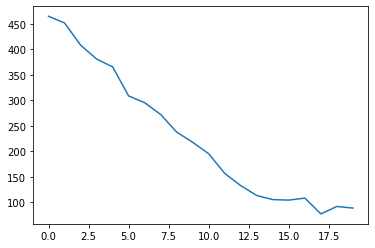

In [14]:
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
loss_indices = [i for i,l in enumerate(losses_float)] 
plt.plot(loss_indices, losses_float)

In [15]:
import pandas as pd 

# Analyze the results for one batch
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch)
    df = pd.DataFrame()
    df["y_real"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()
df["y_real"] = df["y_real"].apply(lambda row: row)
df["y_pred"] = df["y_pred"].apply(lambda row: row)
df

,y_real,y_pred
0,446.000000,[487.01605224609375]
1,600.000000,[487.0160217285156]
2,408.000000,[487.0160827636719]
3,464.000000,[487.0160827636719]
4,522.000000,[487.0160827636719]
...,...,...
59,444.374023,[487.0159606933594]
60,814.000000,[487.0159912109375]
61,796.000000,[487.0159912109375]
62,462.000000,[487.0160827636719]
